In [9]:
# %%
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
%matplotlib inline


In [10]:
# %%
# Set seed for reproducibility
import random
import numpy as np
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [11]:
# %%
# Load dataset
df = pd.read_csv('recruitment_data.csv')

# Define the features and the target class
x = df.drop(columns=['HiringDecision'], axis=1)
y = df['HiringDecision']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Parameters: {'selectkbest__k': 7, 'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
Training Accuracy: 86.38095238095238
Test Accuracy: 87.78%



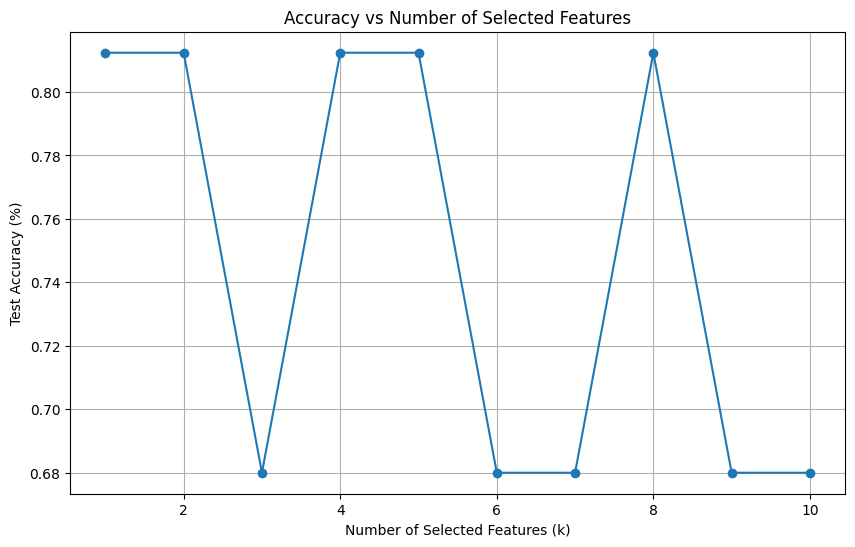

In [12]:
# %%
# Feature Selection and GridSearchCV for Hyperparameter Tuning
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = []

# Define the parameter grid for GridSearchCV
param_grid = {
    'selectkbest__k': k_values,
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['rbf', 'linear', 'sigmoid']
}

# Create pipeline
pipeline = Pipeline([
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True))
])

# Define and fit GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Get the best estimator
best_pipeline = grid_search.best_estimator_

# Evaluate the model
y_pred_train = best_pipeline.predict(x_train)
y_pred_test = best_pipeline.predict(x_test)

train_accuracy = accuracy_score(y_train, y_pred_train) * 100
test_accuracy = accuracy_score(y_test, y_pred_test) * 100

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy:.2f}%\n")

# Plotting accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, grid_search.cv_results_['mean_test_score'][:len(k_values)], marker='o')
plt.title('Accuracy vs Number of Selected Features')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.show()


Best k value: 7
Selected features: ['EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
* Training score: 86.381
* Testing score: 87.778

Accuracy:  87.77777777777777
Recall:  87.77777777777777
Precision:  87.61878581900572
F1-Score:  87.67326175523893


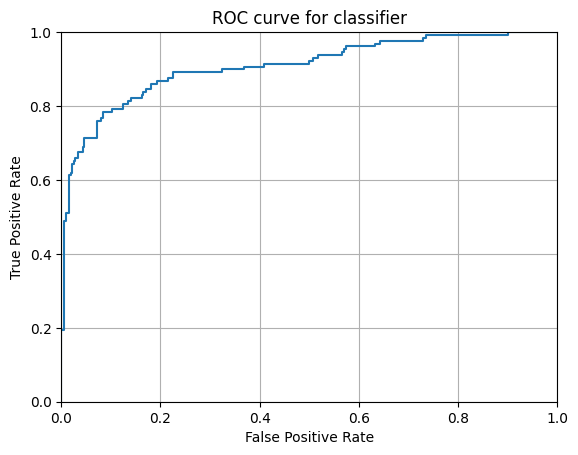

AUC Score: 0.9077978217295759


In [13]:
# %%
# Select the best k value based on the highest accuracy
best_k = grid_search.best_params_['selectkbest__k']
selector = SelectKBest(score_func=f_classif, k=best_k)
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)

# Get the selected feature names
selected_features = x.columns[selector.get_support()].tolist()
print(f"Best k value: {best_k}")
print(f"Selected features: {selected_features}")

# Evaluate the best model
print('* Training score: %.3f' % (best_pipeline.score(x_train, y_train) * 100))
print('* Testing score: %.3f' % (best_pipeline.score(x_test, y_test) * 100))
print()

y_pred = best_pipeline.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred) * 100)
print('Recall: ', recall_score(y_test, y_pred, average='weighted') * 100)
print('Precision: ', precision_score(y_test, y_pred, average='weighted') * 100)
print('F1-Score: ', f1_score(y_test, y_pred, average='weighted') * 100)

# Compute ROC curve and AUC score
y_pred_prob = best_pipeline.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_prob))


<Figure size 800x600 with 0 Axes>

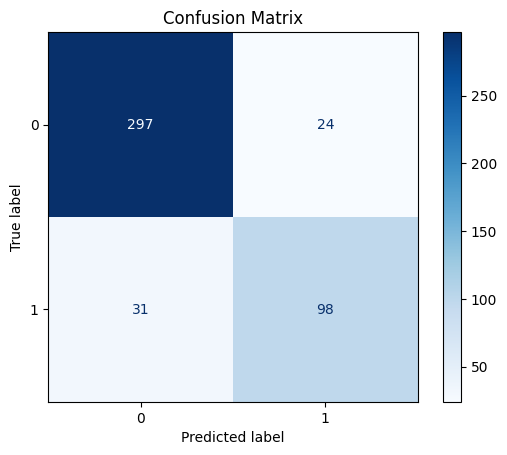

In [14]:
# %%
# Generate the confusion matrix for the SVM model
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_pipeline.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [17]:
import joblib

# Save the best model
joblib_file = "best_svm_model.pkl"
joblib.dump(best_pipeline, joblib_file)

# Load and test the saved model
loaded_model = joblib.load(joblib_file)
print('Loaded model accuracy:', accuracy_score(y_test, loaded_model.predict(x_test)) * 100)
print(loaded_model)

Loaded model accuracy: 87.77777777777777
Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])


In [15]:
import winsound

# Play a sound to indicate the end of the process
winsound.MessageBeep()
